In [1]:
TRAIN_FILE = 'boston_housing/train.csv'
TEST_FILE = 'boston_housing/test.csv'

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold,train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
def data_preprocess(filename, mode='Train', training_data=None):
    """
    :param filename: str, the filename to be read into pandas
    :param mode: str, indicating the mode we are using (either Train or Test)
    :param training_data: DataFrame, a 2D data structure that looks like an excel worksheet
                          (You will only use this when mode == 'Test')
    :return: Tuple(data, labels), if the mode is 'Train'; or return data, if the mode is 'Test'
    """
    data = pd.read_csv(filename)
    labels = None
    if mode == 'Train':
        feature_name = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black',
                        'lstat', 'medv']
        data = data[feature_name]
        labels = data.pop('medv')
    elif mode == 'Test':
        feature_name = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black',
                        'lstat']
        data = data[feature_name]

    if mode == 'Train':
        return data, labels
    elif mode == 'Test':
        return data

In [4]:
def one_hot_encoding(data, feature: list):
    """
    :param data: DataFrame, key is the column name, value is its data
    :param feature: lst, the column name of interest
    :return data: DataFrame, remove the feature column and add its one-hot encoding features
    """
    data = pd.get_dummies(data, prefix=feature, columns=feature, prefix_sep='_')
    return data

In [5]:
def binning(data, column: str, bins):
    data[column] = pd.cut(data[column], bins, labels=[i for i in range(bins)])

In [6]:
def normalization(data, normalizer, mode='Train'):
    if mode == 'Train':
        normalizer = preprocessing.MinMaxScaler()
        data = normalizer.fit_transform(data)
    elif mode == 'Test':
        data = normalizer.transform(data)
    return data, normalizer

In [7]:
def rmse_cv(model, train_data, labels):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse = np.sqrt(-cross_val_score(model, train_data, labels, scoring = "neg_mean_squared_error", cv=kf))
    print(f'{model}_prediction MSE: {rmse.mean()}')

In [8]:
train = pd.read_csv(TRAIN_FILE)
train.pop('ID')
train.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,3.620529,11.437500,11.302697,0.065789,0.552137,6.245053,67.861513,3.848711,9.546053,408.851974,18.518092,358.501743,12.814309,22.108882
std,7.991591,23.167692,6.865398,0.248322,0.113258,0.698285,28.625025,2.106197,8.763741,168.569524,2.140718,89.746798,7.386031,8.718685
min,0.009060,0.000000,0.740000,0.000000,0.389000,3.561000,6.500000,1.137000,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.083437,0.000000,5.190000,0.000000,0.448000,5.876750,43.150000,2.122350,4.000000,281.000000,17.400000,375.997500,7.197500,17.175000
50%,0.276650,0.000000,9.690000,0.000000,0.535000,6.197500,74.950000,3.324600,5.000000,330.000000,19.100000,391.770000,11.170000,21.150000
75%,3.716458,14.375000,18.100000,0.000000,0.624000,6.618250,94.100000,5.141175,24.000000,666.000000,20.200000,396.900000,16.827500,25.000000
max,73.534100,95.000000,27.740000,1.000000,0.871000,8.725000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


The figure layout has changed to tight


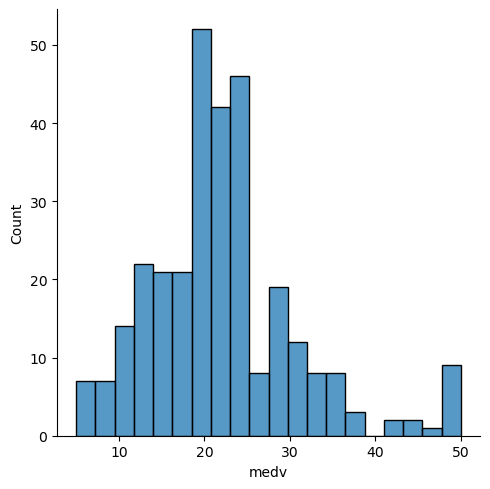

In [9]:
sns.displot(train["medv"])

<Axes: >

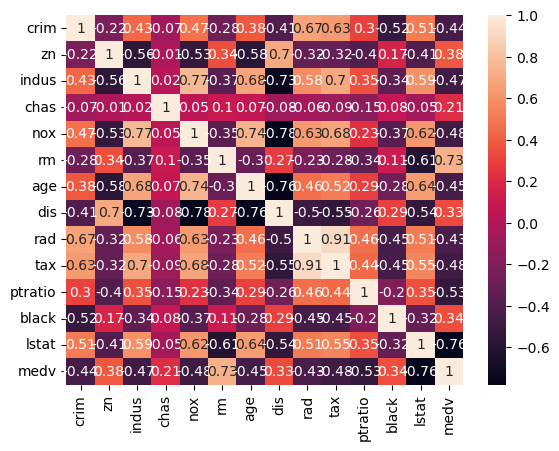

In [10]:
correlation_matrix = train.corr().round(2)
sns.heatmap(data=correlation_matrix, annot = True)

In [11]:
#####training#####
data, y = data_preprocess(TRAIN_FILE, mode='Train')
train_data, val_data, train_labels, val_labels = train_test_split(data, y, test_size=0.25, random_state=777)

In [12]:
train_data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
203,0.06151,0.0,5.19,0,0.515,5.968,58.5,4.8122,5,224,20.2,396.90,9.29
194,0.34109,0.0,7.38,0,0.493,6.415,40.1,4.7211,5,287,19.6,396.90,6.12
76,0.15038,0.0,25.65,0,0.581,5.856,97.0,1.9444,2,188,19.1,370.31,25.41
227,15.87440,0.0,18.10,0,0.671,6.545,99.1,1.5192,24,666,20.2,396.90,21.08
232,24.39380,0.0,18.10,0,0.700,4.652,100.0,1.4672,24,666,20.2,396.90,28.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.57834,20.0,3.97,0,0.575,8.297,67.0,2.4216,5,264,13.0,384.54,7.44
71,0.12329,0.0,10.01,0,0.547,5.913,92.9,2.3534,6,432,17.8,394.95,16.21
87,0.54452,0.0,21.89,0,0.624,6.151,97.9,1.6687,4,437,21.2,396.90,18.46
59,0.03932,0.0,3.41,0,0.489,6.405,73.9,3.0921,2,270,17.8,393.55,8.20


In [13]:
train_data = one_hot_encoding(train_data, ['chas', 'rad'])
val_data = one_hot_encoding(val_data, ['chas','rad'])

In [14]:
# To bining the zn dataset
binning(train_data, 'zn', 5)
binning(val_data, 'zn', 5)

In [15]:
class_names = train_data.columns

In [16]:
normalizer = preprocessing.MinMaxScaler()
train_data = normalizer.fit_transform(train_data)
val_data = normalizer.transform(val_data)

In [17]:
# To use GridSearchCV to find best parameters
params = {'max_depth': [5,6,7,8],
          'learning_rate': [0.01, 0.05, 0.1],
          'colsample_bylevel': [0.2, 0.3, 0.4],
          'reg_alpha': [0.01,0.015,0.03,0.045],
          'n_estimators':[300,500,1000]
         }

xgbr = xgb.XGBRegressor(seed=50)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(train_data, train_labels)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(0.5))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bylevel': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.015}
Lowest RMSE:  3.476536463316725


In [18]:
# Validating
best_model = xgb.XGBRegressor(**clf.best_params_)
best_model.fit(train_data, train_labels)
val_pred = best_model.predict(val_data)
mse = mean_squared_error(val_labels, val_pred)
score = r2_score(val_labels, val_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

Root Mean Square Error: 2.76
Accuracy: 90.52 %


In [19]:
# To illustrate the feature importance via shap
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train_data)

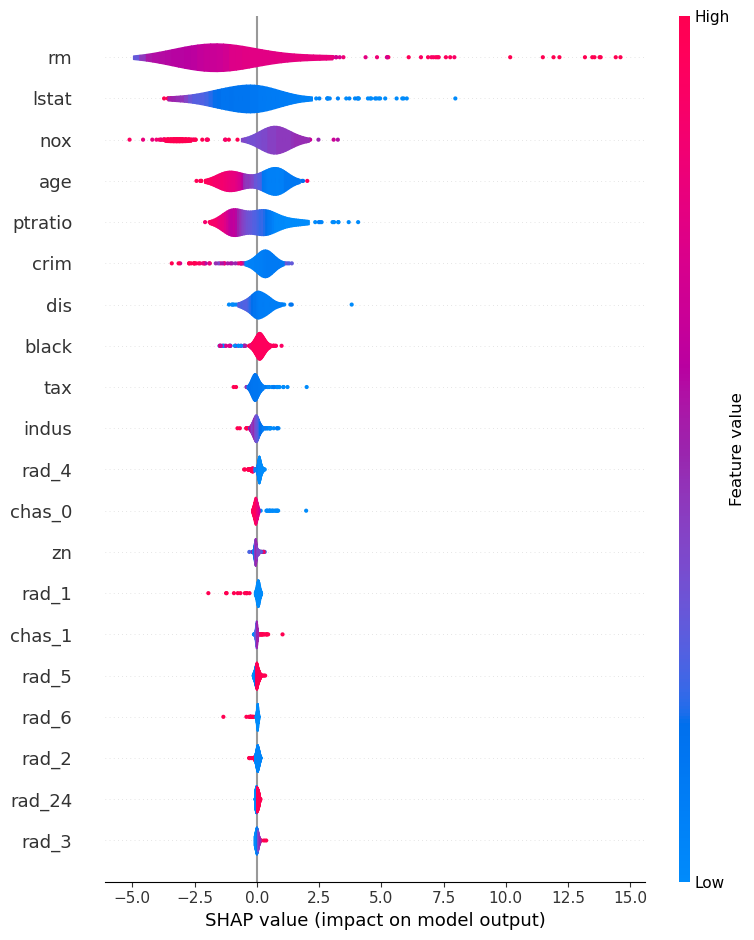

In [20]:
shap.summary_plot(shap_values, train_data, plot_type="violin", feature_names=class_names)

In [21]:
# To write testing output to the file
def write_data(predictions, file_name='result.csv'):
    data = pd.read_csv(TEST_FILE)
    with open(file_name, 'w') as f:
        f.write('ID,medv\n')
        for ID, medv in zip(data['ID'], predictions):
            f.write(f'{ID},{medv}\n')

In [22]:
# Testing dataset
test_data = data_preprocess(TEST_FILE, mode='Test')
test_data = one_hot_encoding(test_data, ['chas','rad'])
binning(test_data, 'zn', 5)
normalizer = preprocessing.MinMaxScaler()
train_data = normalizer.fit_transform(train_data)
test_data = normalizer.transform(test_data)
test_pred = best_model.predict(test_data)

write_data(test_pred,'xgboost_prediction.csv')

X has feature names, but MinMaxScaler was fitted without feature names
